# __CNN을 이용한 개와 고양이 분류__

In [20]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import shutil

from torchvision import transforms
from torchvision import models

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import time
from torchviz import make_dot
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

## GPU 가용 상태 확인

In [9]:
print("Cuda Available : ", torch.cuda.is_available())
print("Available devices : ", torch.cuda.device_count())
print("Current Device Number : ",torch.cuda.current_device())
print("Device Name : ",torch.cuda.get_device_name(device=0))

Cuda Available :  True
Available devices :  2
Current Device Number :  0
Device Name :  GeForce GTX 1080 Ti


In [10]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

# 1. PyTorch Tensor로 데이터 로딩

In [29]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('./data/dogsandcats/train/',simple_transform)
valid = ImageFolder('./data/dogsandcats/valid/',simple_transform)

In [30]:
print(train.class_to_idx)
print(train.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


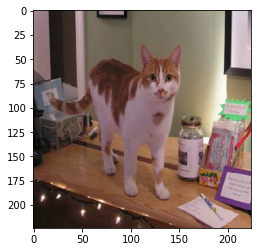

In [31]:
imshow(valid[720][0])

In [32]:
# 데이터 제너레이터 생성

train_data_loader = torch.utils.data.DataLoader(train,batch_size=16,num_workers=8,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=16,num_workers=8,shuffle=True)

# 2. Baseline Model

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 2)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [34]:
model = Net()
if is_cuda:
    model.cuda()

In [35]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [40]:
data, target = next(iter(train_data_loader))
data, target = data.cuda(), target.cuda()

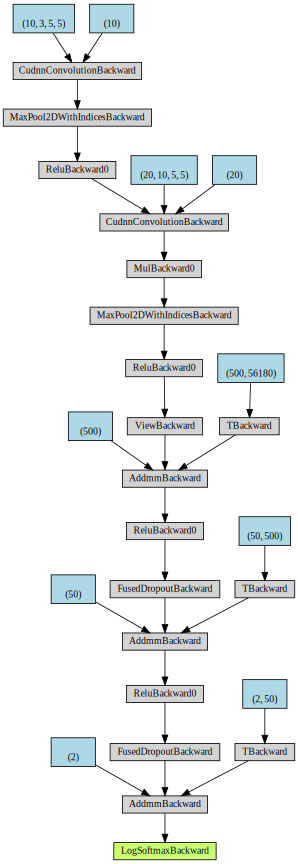

In [41]:
make_dot(model(Variable(data)))

In [42]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
    
    if phase == 'training':
        model.train()
    
    if phase == 'validation':
        model.eval()
        volatile=True
    
    running_loss = 0.0
    running_correct = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        running_loss += F.nll_loss(output, target, size_average=False).data
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct.item() / len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [45]:
%%time
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_data_loader, phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_data_loader, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.11 and training accuracy is 22092/23000     96.05
validation loss is   0.6 and validation accuracy is 1575/2000     78.75
training loss is   0.1 and training accuracy is 22163/23000     96.36
validation loss is  0.63 and validation accuracy is 1558/2000      77.9
training loss is 0.099 and training accuracy is 22218/23000      96.6
validation loss is  0.64 and validation accuracy is 1538/2000      76.9
training loss is 0.092 and training accuracy is 22258/23000     96.77
validation loss is  0.63 and validation accuracy is 1533/2000     76.65
training loss is 0.078 and training accuracy is 22379/23000      97.3
validation loss is  0.65 and validation accuracy is 1538/2000      76.9
training loss is  0.09 and training accuracy is 22314/23000     97.02
validation loss is  0.66 and validation accuracy is 1544/2000      77.2
training loss is 0.073 and training accuracy is 22440/23000     97.57
validation loss is  0.71 and validation accuracy is 1520/2000      76.0
traini

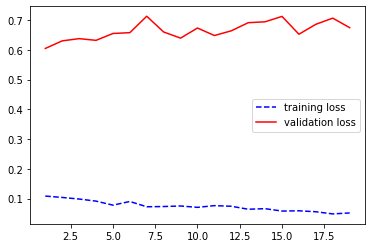

In [51]:
plt.plot(range(1,len(train_losses)+1), train_losses, 'b--', label='training loss')
plt.plot(range(1,len(val_losses)+1), val_losses, 'r', label='validation loss')
plt.legend()

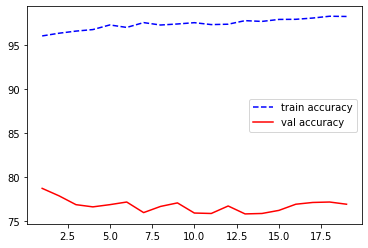

In [46]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'b--', label='train accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label='val accuracy')
plt.legend()

# 3. VGG를 이용한 전이학습(Transfer Learning)
- VGG16 아키텍처는 5개의 VGG 블록으로 구성돼 있다. 
- 각 블록은 여러개의 컨볼루션 레이어와 비선형 활성화 함수 및 맥스 풀링 함수를 포함한다.
- 사전에 학습된 아키텍처를 재사용하여 전이 학습을 진행한다.
- 마지막 몇 개의 선형 레이어만 트레이닝하고 컨볼루션 레이어는 그대로 사용한다.

In [58]:
torch.cuda.empty_cache()

In [59]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [60]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

- 모델 요약 정보를 보면, VGG16은 순차 모델인 features와 classifier로 구성된 것을 확인할 수 있다.
- feature 순차 모델에 포함된 레이어의 학습 파라미터는 전이학습 과정에서 고정된다.

## 3-1) 레이어 고정
- features 모델의 모든 레이어를 고정시키는 설정을 VGG16에 적용한다.
- 고정을 통해 컨볼루션 블록의 학습 파라미터가 학습되지 않도록 보호한다.

In [61]:
# 옵티마이저가 가중치를 업데이트하지 못하게 한다.
for param in vgg.features.parameters():
    param.requires_grad = False

## 3-2) 세부 고정
- VGG16 모델은 1000개의 카테고리를 분류하도록 학습됐다.
- 여기서는 개와 고양이 만을 분류하기 때문에 마지막 레이어의 출력을 1000에서 2로 변경한다.

In [62]:
# 모델 내부의 모든 레이어에 접근이 가능하다.
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [64]:
vgg.classifier[6].out_features = 2
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [66]:
# VGG16 모델을 전이학습할 때, classifier 내부 요소만 학습을 시킨다. 따라서 classifier.parameters를 Optimizer에 전달한다.
optimizer = optim.SGD(vgg.classifier.parameters(), lr=0.0001, momentum=0.5)

## 3-3) VGG16 모델 학습
- 앞서서 사용했던 데이터 로더 코드와 fit함수를 사용해 모델을 학습시킨다.
- 모델을 학습 시킬 때는 classifier 내부의 매개변수만 변경된다.

In [67]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss.item() /len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [68]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    # vgg 모델 입력
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/pirl/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   1.7 and training accuracy is 17849/23000      77.6
validation loss is  0.11 and validation accuracy is 1933/2000     96.65
training loss is 0.099 and training accuracy is 22293/23000     96.93
validation loss is 0.077 and validation accuracy is 1948/2000      97.4
training loss is 0.073 and training accuracy is 22461/23000     97.66
validation loss is 0.068 and validation accuracy is 1954/2000      97.7
training loss is 0.063 and training accuracy is 22519/23000     97.91
validation loss is 0.064 and validation accuracy is 1958/2000      97.9
training loss is 0.056 and training accuracy is 22561/23000     98.09
validation loss is 0.062 and validation accuracy is 1959/2000     97.95
training loss is 0.051 and training accuracy is 22601/23000     98.27
validation loss is 0.059 and validation accuracy is 1961/2000     98.05
training loss is  0.05 and training accuracy is 22592/23000     98.23
validation loss is 0.057 and validation accuracy is 1961/2000     98.05
traini

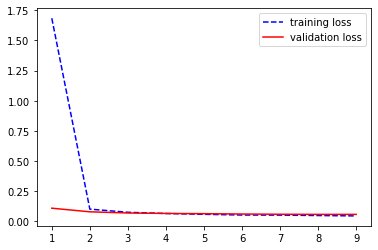

In [69]:
plt.plot(range(1,len(train_losses)+1), train_losses, 'b--', label='training loss')
plt.plot(range(1,len(val_losses)+1), val_losses, 'r', label='validation loss')
plt.legend()

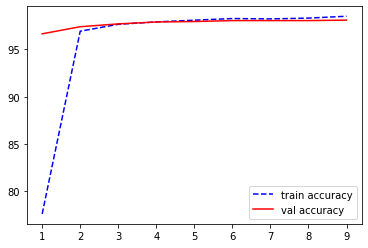

In [70]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'b--', label='train accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label='val accuracy')
plt.legend()

## 3-4) Dropout 적용
- VGG classifier 모듈의 드롭아웃 값을 0.5에서 0.2로 변경하고 모델을 학습시킨다.

In [71]:
for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [72]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/pirl/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 0.032 and training accuracy is 22745/23000     98.89
validation loss is 0.054 and validation accuracy is 1964/2000      98.2
training loss is 0.031 and training accuracy is 22748/23000      98.9
validation loss is 0.053 and validation accuracy is 1964/2000      98.2
CPU times: user 3min 5s, sys: 6.65 s, total: 3min 12s
Wall time: 3min 13s


- VGG 모델의 Dropout 비율을 변경한 후, 3 epoch의 추가 학습을 통해서 성능 개선을 이룰 수 있다.

## 3-5) Data Augmentation
- 모델의 일반화 성능을 높이는 데에는 더 많은 데이터를 수집하거나 Data Augmentation을 사용할 수 있다.
- 파이토치의 torchvision 라이브러리에는 데이터를 증식하는 다양한 기능을 제공한다.
- 파이토치는 Data Augmentation과 관련된 기능을 동적으로 수행하며, 데이터는 Epoch 별로 변경된다.

In [73]:
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
train = ImageFolder('./data/dogsandcats/train/',simple_transform)
valid = ImageFolder('./data/dogsandcats/valid/',simple_transform)

In [74]:
train_data_loader = DataLoader(train,batch_size=32,num_workers=8,shuffle=True)
valid_data_loader = DataLoader(valid,batch_size=32,num_workers=8,shuffle=True)

In [76]:
# Training

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/pirl/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.03 and training accuracy is 22770/23000      99.0
validation loss is 0.052 and validation accuracy is 1964/2000      98.2
training loss is 0.029 and training accuracy is 22776/23000     99.03
validation loss is 0.052 and validation accuracy is 1964/2000      98.2


# 4. 사전 계산된 Convolution Feature 사용(Preconvoluted Feature)
- Convolution Layer의 학습 파라미터를 고정하고 모델을 학습하면 Fully Connected Layer나 Dense Layer(vgg.classifier)의 입력은 항상 데이터별로 같은 값이 입력된다.
- Convolution Block은 학습에 참여하지만, 학습 중에 학습 Parameter의 변경은 발생하지 않는다.
- 입력 별로 Convolution Block의 계산 결과를 저장하고 재사용하면, 학습속도를 상당히 개선할 수 있다.
- 모든 Epoch에서 Conv Block 계산을 반복하는 것이 아니라 첫 번째 Epoch에서 계산한 Conv Block의 결과를 재사용하기 때문에 모델 학습 시간은 줄어든다.

In [85]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [86]:
features = vgg.features

In [87]:
for param in features.parameters(): 
    param.requires_grad = False

In [88]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=8,shuffle=False)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=8,shuffle=False)

In [91]:
def preconvfeat(dataset,model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if is_cuda:
            inputs , labels = inputs.cuda(),labels.cuda()       
        inputs , labels = Variable(inputs),Variable(labels)
        output = model(inputs)
        conv_features.extend(output.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    
    return (conv_features,labels_list)

In [92]:
conv_feat_train, labels_train = preconvfeat(train_data_loader, features)
conv_feat_val, labels_val = preconvfeat(valid_data_loader, features)